In [1]:
import xarray as xr #work with arrays
import numpy as np #additional functions for arrays
import pandas as pd #Open csv files
import matplotlib.pyplot as plt #plotting (used as checks to make sure everything works)
import csv #write csv

#Function that takes the weighted mean of the given area
def mean_2D(var, weights):
    # assumes 2D field as var input

    # make sure masking is correct, otherwise we get nans
    var = np.ma.masked_invalid(var)
    weights =  np.ma.masked_invalid(weights)
    # resulting variable should have dimensions of depth and time (x)
    ave = np.zeros(var.shape[0])

    # loop over time
    #for t in np.arange(var.shape[0]):
    ave = np.ma.average(var[:, :], weights=weights)
    return ave

#File containing the country mask
country_masks = xr.open_dataset('/glade/work/vgarza/nuclear_ocean/gadm0_regrid.mask.nc4')

#Cell area weights derived from the country masks
weights = xr.open_dataset('/glade/work/vgarza/nuclear_ocean/gadm0_regrid.weights.nc4')

#CSV file containing the nation id and the nation name
nationIDname = pd.read_csv('/glade/work/vgarza/nuclear_ocean/nationIDname.csv')

In [7]:
np.version.version

'2.1.3'

In [8]:
country_masks

<xarray.Dataset> Size: 113kB
Dimensions:  (lon: 144, lat: 96)
Coordinates:
  * lon      (lon) float64 1kB 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float64 768B -89.06 -87.19 -85.31 ... 85.31 87.19 89.06
Data variables:
    gadm0    (lat, lon) float64 111kB nan nan nan nan nan ... nan nan nan nan
Attributes:
    CDI:           Climate Data Interface version 2.3.0 (https://mpimet.mpg.d...
    Conventions:   CF-1.6
    person_notes:  Joshua Elliott
    history:       Thu Mar 06 09:52:43 2025: cdo remapbil,r144x96 ./gadm0.mas...
    CDO:           Climate Data Operators version 2.3.0 (https://mpimet.mpg.d...

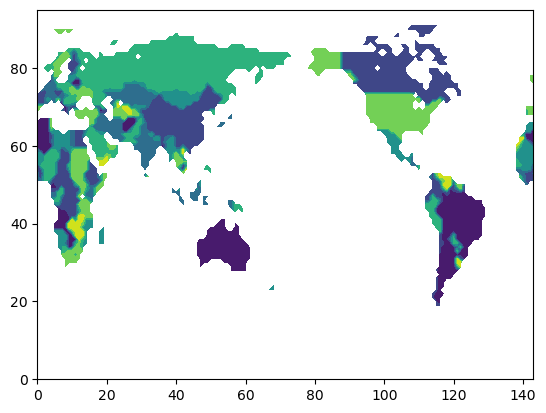

In [9]:
plt.contourf(country_masks['gadm0'])

In [10]:
weights

<xarray.Dataset> Size: 113kB
Dimensions:    (lon: 144, lat: 96)
Coordinates:
  * lon        (lon) float64 1kB 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * lat        (lat) float64 768B -89.06 -87.19 -85.31 ... 85.31 87.19 89.06
Data variables:
    cell_area  (lat, lon) float64 111kB ...
Attributes:
    CDI:          Climate Data Interface version 2.3.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Thu Mar 06 10:06:02 2025: cdo gridarea ./gadm0_regrid.mask....
    CDO:          Climate Data Operators version 2.3.0 (https://mpimet.mpg.de...

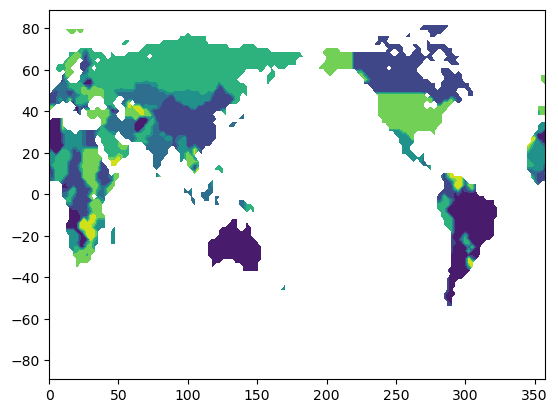

In [11]:
plt.contourf(country_masks['lon'], country_masks['lat'], country_masks['gadm0'])

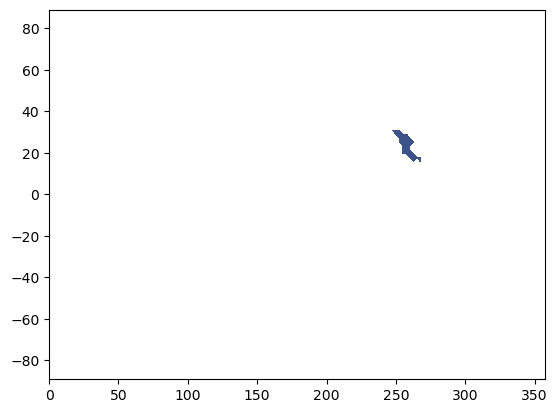

In [12]:
#A quick check to see if the method for isolating a country works
one = np.zeros([96, 144])
one[:] = np.nan
one[(country_masks['gadm0']) == 145] = 0

plt.contourf(country_masks['lon'], country_masks['lat'], one)

## Change variables on the next cell:

### Control:
'/glade/work/vgarza/nuclear_ocean/scratch/alpine/joco6825/dwinstead_data/nw_cntrl_03/nw_cntrl_03.cam.h0.*.nc'
Years: 1 - 21
### nw_targets_04
'/glade/work/vgarza/nuclear_ocean/scratch/alpine/joco6825/dwinstead_data/nw_targets_04/nw_targets_04.cam.h0.*.nc'
Years: 5 - 19

### nw_targets_05
'/glade/work/vgarza/nuclear_ocean/scratch/alpine/joco6825/dwinstead_data/nw_targets_05/nw_targets_05.cam.h0.*.nc'
Years: 5 - 19

### nw_ur_150
'/glade/work/vgarza/nuclear_ocean/scratch/alpine/joco6825/dwinstead_data/nw_ur_150_07/nw_ur_150_07.cam.h0.*.nc'
Years: 5 - 34

In [15]:
#The dataset you would like to use
dataset =  xr.open_mfdataset('/glade/work/vgarza/nuclear_ocean/scratch/alpine/joco6825/dwinstead_data/nw_cntrl_03/nw_cntrl_03.cam.h0.*.nc')

#The directory you would like to save the file to
outpath = '/glade/work/vgarza/nuclear_ocean/output/rerun/'
#A list of file names to save the files in
outfile_names = 'nw_cntrl_03.PRECT.country_mean.csv'

#Start year and end year
startYear, endYear =  1, 21

In [16]:
#data = []


index = 0

#Organize the file structure and remove an existing file if present
outfile = outpath + outfile_names
!rm $outfile


file = open(outfile, 'w')
writer = csv.writer(file)

row = ['ID', 'Nation']

#fill out the dates 
for year in range(startYear, endYear+1):
    for month in range(1, 12+1):
        row.append(str(year).zfill(4) + ' - ' + str(month).zfill(2))
writer.writerow(row)

#Loop through each nation
for nation_id in (nationIDname['GGCMI-nation-ID'][:]):

    #Isolate get the mask for the nation and add the country row to the csv
    print(nationIDname['crop model output'][index])
    nation_mask = np.zeros([96, 144])
    nation_mask[:] = np.nan
    nation_mask[(country_masks['gadm0']) == nation_id] = 0

    row = [nation_id, nationIDname['crop model output'][index]]

    #Loop through time
    for time in range(0, (endYear - startYear+1) * 12):
            #Isolate the country and calculate the weighted mean
            #country_mean = dataset[variable][time,:,:] - nation_mask
            var = mean_2D((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask),weights['cell_area'])

            #If everythin is zeros, save na
            if type(var) == np.ma.core.MaskedConstant:
                #print("nan")
                var = str('NA')
            #save variable to csv file
            row.append(var)
        
    writer.writerow(row)
    #plt.contourf(country_masks['lon'],country_masks['lat'],nation_mask)
    #plt.show()
    #Go to the next country
    index += 1

file.close()


Afghanistan
Albania
Brazil
British Indian Ocean Territory
British Virgin Islands
Brunei
Bulgaria
Burkina Faso
Burundi
Cambodia
Cameroon
Canada
Cape Verde
Caspian Sea
Cayman Islands
Central African Republic
Chad
Chile
China
Christmas Island
Cocos Islands
Colombia
Comoros
Cook Islands
Costa Rica
C??te d'Ivoire
Croatia
Cuba
Cura??ao
Cyprus
Czech Republic
Democratic Republic of the Congo
Denmark
Djibouti
Dominica
Dominican Republic
East Timor
Ecuador
Egypt
El Salvador
Equatorial Guinea
Eritrea
Estonia
Ethiopia
Falkland Islands
Faroe Islands
Fiji
Finland
France
French Guiana
French Polynesia
French Southern Territories
Gabon
Gambia
Georgia
Germany
Ghana
Greece
Grenada
Guadeloupe
Guam
Guatemala
Guernsey
Guinea
Guinea-Bissau
Guyana
Haiti
Heard Island and McDonald Islands
Honduras
Hungary
Iceland
India
Indonesia
Iran
Iraq
Ireland
Isle of Man
Israel
Italy
Jamaica
Japan
Jersey
Jordan
Kazakhstan
Kenya
Kiribati
Kosovo
Kuwait
Kyrgyzstan
Laos
Latvia
Lebanon
Lesotho
Liberia
Libya
Lithuania
Luxembourg

## Calculate Min

In [29]:
#A list of file names to save the files in
outfile_names = 'nw_ur_150_07.PRECT.country_mean.min.csv'

#data = []


index = 0

#Organize the file structure
outfile = outpath + outfile_names
!rm $outfile
file = open(outfile, 'w')
writer = csv.writer(file)

row = ['ID', 'Nation']

for year in range(startYear, endYear+1):
    for month in range(1, 12+1):
        row.append(str(year).zfill(4) + ' - ' + str(month).zfill(2))
writer.writerow(row)

#Loop through each nation
for nation_id in (nationIDname['GGCMI-nation-ID'][:]):

    #Isolate get the mask for the nation and add the country row to the csv
    print(nationIDname['crop model output'][index])
    nation_mask = np.zeros([96, 144])
    nation_mask[:] = np.nan
    nation_mask[(country_masks['gadm0']) == nation_id] = 0

    row = [nation_id, nationIDname['crop model output'][index]]

    #Loop through time
    for time in range(0, (endYear - startYear+1) * 12):
            #Isolate the country and calculate the weighted mean
        
            
            var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))

            #If everythin is zeros, save na
            if type(var) == np.ma.core.MaskedConstant:
                #print("nan")
                var = str('NA')
            #save variable to csv file
            row.append(var)
        
    writer.writerow(row)
    #plt.contourf(country_masks['lon'],country_masks['lat'],nation_mask)
    #plt.show()
    #Go to the next country
    index += 1

file.close()


rm: cannot remove '/glade/work/vgarza/nuclear_ocean/output/rerun/nw_ur_150_07.PRECT.country_mean.min.csv': No such file or directory
Afghanistan
Albania
Algeria
American Samoa


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encount

Angola
Antigua and Barbuda
Argentina
Armenia
Aruba
Australia
Austria
Azerbaijan
Bahamas


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encount

Bahrain


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encount

Bangladesh
Barbados


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encount

Belarus
Belgium
Belize


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encount

Benin
Bermuda
Bhutan


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encount

Bolivia
Bonaire, Saint Eustatius and Saba


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encount

Bosnia and Herzegovina
Botswana
Bouvet Island
Brazil
British Indian Ocean Territory


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encount

British Virgin Islands


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encount

Brunei
Bulgaria
Burkina Faso
Burundi
Cambodia
Cameroon
Canada
Cape Verde


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encount

Caspian Sea
Cayman Islands


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encount

Central African Republic
Chad
Chile
China
Christmas Island


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encount

Cocos Islands


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encount

Colombia
Comoros


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encount

Cook Islands
Costa Rica
C??te d'Ivoire
Croatia
Cuba
Cura??ao
Cyprus
Czech Republic
Democratic Republic of the Congo
Denmark
Djibouti
Dominica
Dominican Republic
East Timor
Ecuador
Egypt
El Salvador


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encount

Equatorial Guinea
Eritrea
Estonia
Ethiopia
Falkland Islands
Faroe Islands


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encount

Fiji
Finland
France
French Guiana
French Polynesia


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encount

French Southern Territories
Gabon
Gambia


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encount

Georgia
Germany
Ghana
Greece
Grenada
Guadeloupe
Guam
Guatemala
Guernsey
Guinea
Guinea-Bissau
Guyana
Haiti
Heard Island and McDonald Islands
Honduras
Hungary
Iceland
India
Indonesia
Iran
Iraq
Ireland
Isle of Man
Israel
Italy
Jamaica
Japan
Jersey
Jordan
Kazakhstan
Kenya
Kiribati


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encount

Kosovo


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encount

Kuwait
Kyrgyzstan
Laos
Latvia
Lebanon
Lesotho
Liberia
Libya
Lithuania
Luxembourg
Macedonia
Madagascar
Malawi
Malaysia
Maldives


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encount

Mali
Malta


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encount

Marshall Islands


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encount

Martinique
Mauritania
Mauritius
Mayotte


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encount

Mexico
Micronesia


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encount

Moldova
Mongolia
Montenegro


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encount

Montserrat
Morocco
Mozambique
Myanmar
Namibia
Nauru
Nepal
Netherlands
New Caledonia
New Zealand
Nicaragua
Niger
Nigeria
Niue
Norfolk Island
North Korea
Northern Mariana Islands


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encount

Norway
Oman
Pakistan
Palau


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encount

Palestina
Panama
Papua New Guinea
Paraguay
Peru
Philippines
Pitcairn Islands
Poland
Portugal
Puerto Rico
Qatar
Republic of Congo
Reunion
Romania
Russia
Rwanda


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encount

Saint Helena


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encount

Saint Kitts and Nevis
Saint Lucia


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encount

Saint Pierre and Miquelon
Saint Vincent and the Grenadines
Saint-Martin
Samoa


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encount

Sao Tome and Principe


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encount

Saudi Arabia
Senegal
Serbia
Seychelles


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encount

Sierra Leone
Singapore
Slovakia


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encount

Slovenia
Solomon Islands
Somalia
South Africa
South Georgia and the South Sandwich Islands
South Korea
South Sudan
Spain
Sri Lanka
Sudan
Suriname
Svalbard and Jan Mayen
Swaziland


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encount

Sweden
Switzerland
Syria
Taiwan


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encount

Tajikistan
Tanzania
Thailand
Togo
Tonga


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encount

Trinidad and Tobago


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encount

Tunisia
Turkey
Turkmenistan
Turks and Caicos Islands
Tuvalu


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encount

Uganda
Ukraine
United Arab Emirates
United Kingdom
United States
United States Minor Outlying Islands


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encount

Uruguay
Uzbekistan
Vanuatu
Venezuela
Vietnam
Virgin Islands, U.S.


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encount

Wallis and Futuna


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmin(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/3092094256.py:38: RuntimeWarning: All-NaN axis encount

Western Sahara
Yemen
Zambia
Zimbabwe


## Calculate Max

In [30]:
#A list of file names to save the files in
outfile_names = 'nw_ur_150_07.PRECT.country_mean.max.csv'

#data = []


index = 0

#Organize the file structure
outfile = outpath + outfile_names
!rm $outfile

file = open(outfile, 'w')
writer = csv.writer(file)

row = ['ID', 'Nation']

for year in range(startYear, endYear+1):
    for month in range(1, 12+1):
        row.append(str(year).zfill(4) + ' - ' + str(month).zfill(2))
writer.writerow(row)

#Loop through each nation
for nation_id in (nationIDname['GGCMI-nation-ID'][:]):

    #Isolate get the mask for the nation and add the country row to the csv
    print(nationIDname['crop model output'][index])
    nation_mask = np.zeros([96, 144])
    nation_mask[:] = np.nan
    nation_mask[(country_masks['gadm0']) == nation_id] = 0

    row = [nation_id, nationIDname['crop model output'][index]]

    #Loop through time
    for time in range(0, (endYear - startYear+1) * 12):
            #Isolate the country and calculate the weighted mean
            #country_mean = dataset[variable][time,:,:] - nation_mask
            var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))

            #If everythin is zeros, save na
            if type(var) == np.ma.core.MaskedConstant:
                #print("nan")
                var = str('NA')
            #save variable to csv file
            row.append(var)
        
    writer.writerow(row)
    #plt.contourf(country_masks['lon'],country_masks['lat'],nation_mask)
    #plt.show()
    #Go to the next country
    index += 1

file.close()


rm: cannot remove '/glade/work/vgarza/nuclear_ocean/output/rerun/nw_ur_150_07.PRECT.country_mean.max.csv': No such file or directory
Afghanistan
Albania
Algeria
American Samoa


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encount

Angola
Antigua and Barbuda
Argentina
Armenia
Aruba
Australia
Austria
Azerbaijan
Bahamas


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encount

Bahrain


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encount

Bangladesh
Barbados


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encount

Belarus
Belgium
Belize


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encount

Benin
Bermuda
Bhutan


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encount

Bolivia
Bonaire, Saint Eustatius and Saba


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encount

Bosnia and Herzegovina
Botswana
Bouvet Island
Brazil
British Indian Ocean Territory


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encount

British Virgin Islands


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encount

Brunei
Bulgaria
Burkina Faso
Burundi
Cambodia
Cameroon
Canada
Cape Verde


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encount

Caspian Sea
Cayman Islands


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encount

Central African Republic
Chad
Chile
China
Christmas Island


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encount

Cocos Islands


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encount

Colombia
Comoros


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encount

Cook Islands
Costa Rica
C??te d'Ivoire
Croatia
Cuba
Cura??ao
Cyprus
Czech Republic
Democratic Republic of the Congo
Denmark
Djibouti
Dominica
Dominican Republic
East Timor
Ecuador
Egypt
El Salvador


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encount

Equatorial Guinea
Eritrea
Estonia
Ethiopia
Falkland Islands
Faroe Islands


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encount

Fiji
Finland
France
French Guiana
French Polynesia


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encount

French Southern Territories
Gabon
Gambia


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encount

Georgia
Germany
Ghana
Greece
Grenada
Guadeloupe
Guam
Guatemala
Guernsey
Guinea
Guinea-Bissau
Guyana
Haiti
Heard Island and McDonald Islands
Honduras
Hungary
Iceland
India
Indonesia
Iran
Iraq
Ireland
Isle of Man
Israel
Italy
Jamaica
Japan
Jersey
Jordan
Kazakhstan
Kenya
Kiribati


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encount

Kosovo


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encount

Kuwait
Kyrgyzstan
Laos
Latvia
Lebanon
Lesotho
Liberia
Libya
Lithuania
Luxembourg
Macedonia
Madagascar
Malawi
Malaysia
Maldives


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encount

Mali
Malta


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encount

Marshall Islands


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encount

Martinique
Mauritania
Mauritius
Mayotte


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encount

Mexico
Micronesia


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encount

Moldova
Mongolia
Montenegro


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encount

Montserrat
Morocco
Mozambique
Myanmar
Namibia
Nauru
Nepal
Netherlands
New Caledonia
New Zealand
Nicaragua
Niger
Nigeria
Niue
Norfolk Island
North Korea
Northern Mariana Islands


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encount

Norway
Oman
Pakistan
Palau


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encount

Palestina
Panama
Papua New Guinea
Paraguay
Peru
Philippines
Pitcairn Islands
Poland
Portugal
Puerto Rico
Qatar
Republic of Congo
Reunion
Romania
Russia
Rwanda


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encount

Saint Helena


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encount

Saint Kitts and Nevis
Saint Lucia


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encount

Saint Pierre and Miquelon
Saint Vincent and the Grenadines
Saint-Martin
Samoa


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encount

Sao Tome and Principe


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encount

Saudi Arabia
Senegal
Serbia
Seychelles


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encount

Sierra Leone
Singapore
Slovakia


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encount

Slovenia
Solomon Islands
Somalia
South Africa
South Georgia and the South Sandwich Islands
South Korea
South Sudan
Spain
Sri Lanka
Sudan
Suriname
Svalbard and Jan Mayen
Swaziland


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encount

Sweden
Switzerland
Syria
Taiwan


/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encountered
  var = (np.nanmax(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask))))
/glade/derecho/scratch/vgarza/tmp/ipykernel_29585/2983278206.py:38: RuntimeWarning: All-NaN axis encount

In [ ]:
import math
def weighted_std(values, weights):
    """
    Return the weighted average and standard deviation.

    They weights are in effect first normalized so that they 
    sum to 1 (and so they must not all be 0).

    values, weights -- NumPy ndarrays with the same shape.
    """
    weights = np.ma.masked_invalid(weights)
    values = np.ma.masked_invalid(
        values)
    
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return (math.sqrt(variance))

## Calculate Standard Deviation

In [ ]:
#A list of file names to save the files in
outfile_names = 'nw_cntrl_03.PRECT.country_mean.stdev.csv'

#data = []


index = 0

#Organize the file structure
outfile = outpath + outfile_names
!rm $outfile
file = open(outfile, 'w')
writer = csv.writer(file)

row = ['ID', 'Nation']

for year in range(startYear, endYear+1):
    for month in range(1, 12+1):
        row.append(str(year).zfill(4) + ' - ' + str(month).zfill(2))
writer.writerow(row)

#Loop through each nation
for nation_id in (nationIDname['GGCMI-nation-ID'][:]):

    #Isolate get the mask for the nation and add the country row to the csv
    print(nationIDname['crop model output'][index])
    nation_mask = np.zeros([96, 144])
    nation_mask[:] = np.nan
    nation_mask[(country_masks['gadm0']) == nation_id] = 0

    row = [nation_id, nationIDname['crop model output'][index]]

    #Loop through time
    for time in range(0, (endYear - startYear+1) * 12):
            #Isolate the country and calculate the weighted mean
            #country_mean = dataset[variable][time,:,:] - nation_mask
            var = (weighted_std(((dataset['PRECC'][time, :, :] - nation_mask) + (dataset['PRECL'][time, :, :] - nation_mask)), weights['cell_area']))

            #If everythin is zeros, save na
            if type(var) == np.ma.core.MaskedConstant:
                #print("nan")
                var = str('NA')
            #save variable to csv file
            row.append(var)
        
    writer.writerow(row)
    #plt.contourf(country_masks['lon'],country_masks['lat'],nation_mask)
    #plt.show()
    #Go to the next country
    index += 1

file.close()


Afghanistan
Albania
Algeria
American Samoa


/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/11405116

Angola
Antigua and Barbuda
Argentina
Armenia
Aruba
Australia
Austria
Azerbaijan
Bahamas


/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/11405116

Bahrain


/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/11405116

Bangladesh
Barbados


/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/11405116

Belarus
Belgium
Belize


/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/11405116

Benin
Bermuda
Bhutan


/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/11405116

Bolivia
Bonaire, Saint Eustatius and Saba


/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/11405116

Bosnia and Herzegovina
Botswana
Bouvet Island
Brazil
British Indian Ocean Territory


/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/11405116

British Virgin Islands


/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/11405116

Brunei
Bulgaria
Burkina Faso
Burundi
Cambodia
Cameroon
Canada
Cape Verde


/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/11405116

Caspian Sea
Cayman Islands


/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/11405116

Central African Republic
Chad
Chile
China
Christmas Island


/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/11405116

Cocos Islands


/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/11405116

Colombia
Comoros


/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/11405116

Cook Islands
Costa Rica
C??te d'Ivoire
Croatia
Cuba
Cura??ao
Cyprus
Czech Republic
Democratic Republic of the Congo
Denmark
Djibouti
Dominica
Dominican Republic
East Timor
Ecuador
Egypt
El Salvador


/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/11405116

Equatorial Guinea
Eritrea
Estonia
Ethiopia
Falkland Islands
Faroe Islands


/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/11405116

Fiji
Finland
France
French Guiana
French Polynesia


/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/11405116

French Southern Territories
Gabon
Gambia


/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/11405116

Georgia
Germany
Ghana
Greece
Grenada
Guadeloupe
Guam
Guatemala
Guernsey
Guinea
Guinea-Bissau
Guyana
Haiti
Heard Island and McDonald Islands
Honduras
Hungary
Iceland
India
Indonesia
Iran
Iraq
Ireland
Isle of Man
Israel
Italy
Jamaica
Japan
Jersey
Jordan
Kazakhstan
Kenya
Kiribati


/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/11405116

Kosovo


/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/11405116

Kuwait
Kyrgyzstan
Laos
Latvia
Lebanon
Lesotho
Liberia
Libya
Lithuania
Luxembourg
Macedonia
Madagascar
Malawi
Malaysia
Maldives


/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/11405116

Mali
Malta


/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/11405116

Marshall Islands


/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/11405116

Martinique
Mauritania
Mauritius
Mayotte


/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/11405116

Mexico
Micronesia


/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/11405116

Moldova
Mongolia
Montenegro


/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/11405116

Montserrat
Morocco
Mozambique
Myanmar
Namibia
Nauru
Nepal
Netherlands
New Caledonia
New Zealand
Nicaragua
Niger
Nigeria
Niue
Norfolk Island
North Korea
Northern Mariana Islands


/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/11405116

Norway
Oman
Pakistan
Palau


/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/11405116

Palestina
Panama
Papua New Guinea
Paraguay
Peru
Philippines
Pitcairn Islands
Poland
Portugal
Puerto Rico
Qatar
Republic of Congo
Reunion
Romania
Russia
Rwanda


/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/11405116

Saint Helena


/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/11405116

Saint Kitts and Nevis
Saint Lucia


/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/11405116

Saint Pierre and Miquelon
Saint Vincent and the Grenadines
Saint-Martin
Samoa


/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/11405116

Sao Tome and Principe


/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/11405116

Saudi Arabia
Senegal
Serbia
Seychelles


/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/11405116

Sierra Leone
Singapore
Slovakia


/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/11405116

Slovenia
Solomon Islands
Somalia
South Africa
South Georgia and the South Sandwich Islands
South Korea
South Sudan
Spain
Sri Lanka
Sudan
Suriname
Svalbard and Jan Mayen
Swaziland


/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/11405116

Sweden
Switzerland
Syria
Taiwan


/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/11405116

Tajikistan
Tanzania
Thailand
Togo
Tonga


/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/11405116

Trinidad and Tobago


/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/11405116

Tunisia
Turkey
Turkmenistan
Turks and Caicos Islands
Tuvalu


/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/11405116

Uganda
Ukraine
United Arab Emirates
United Kingdom
United States
United States Minor Outlying Islands


/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/11405116

Uruguay
Uzbekistan
Vanuatu
Venezuela
Vietnam
Virgin Islands, U.S.


/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/11405116

Wallis and Futuna


/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/1140511630.py:18: UserWarning: Warning: converting a masked element to nan.
  return (math.sqrt(variance))
/glade/derecho/scratch/vgarza/tmp/ipykernel_64614/11405116

Western Sahara
Yemen
Zambia
Zimbabwe


In [1]:
print('Done')

Done
